# **0. Importing Libraries**

In [ ]:
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d moltean/fruits

 99% 1.27G/1.28G [00:09<00:00, 210MB/s]
100% 1.28G/1.28G [00:09<00:00, 146MB/s]


In [ ]:
!unzip fruits.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360_dataset/

In [ ]:
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import cv2
import copy
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

import torch
import torchvision
from torchvision.datasets import ImageFolder

from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

# **1. Data loading and preparation¶**
**Paths**

In [ ]:
example_train_path = '/content/fruits-360_dataset/fruits-360/Training/' 
path = '/content/fruits-360_dataset/fruits-360/'

**Show example from data and size**

Shape: (100, 100, 3)


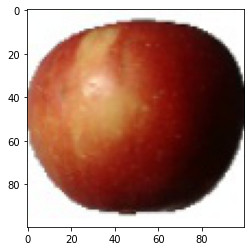

In [ ]:
img = mpimg.imread(example_train_path + "Apple Braeburn/0_100.jpg")
print("Shape:", img.shape)
plt.imshow(img);

**Sometimes the data is normalized in advance, but as you can see in the graph, this is not the case, so the data will have to be normalized**

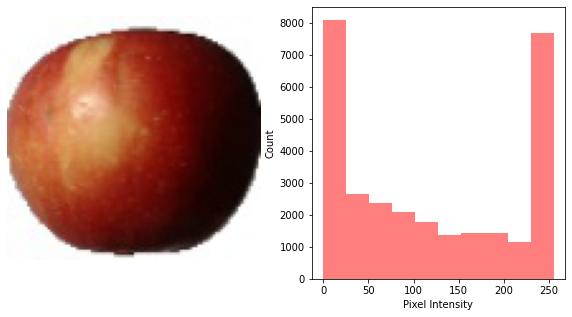

In [ ]:
def plotHist(img):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, color='r', alpha=0.5)

plotHist(img)

**Normalize and load the data**

In [ ]:
transformer = transform.Compose([transform.ToTensor(),
                                transform.Normalize([0.6840562224388123, 0.5786514282226562, 0.5037682056427002],
                                                    [0.3034113645553589, 0.35993242263793945, 0.39139702916145325])
                                ])

In [ ]:
bs = 50

training = ImageFolder(path+'/Training', transform=transformer)

trainset, valset = train_test_split(training, test_size=0.05, shuffle=True, random_state=9)

loaders = {
            'train':DataLoader(trainset, batch_size=bs, num_workers=4, pin_memory=False), #, num_workers=4, pin_memory=False
            'val': DataLoader(valset, batch_size=bs, num_workers=4, pin_memory=False)
          }

dataset_sizes = {
                 'train':len(trainset), 
                 'val':len(valset)
                }

**Let's check the average and standard deviation of the images for each channel. As we can observe, the standard deviation is near one, and the mean is near zero, which is what we need**

In [ ]:
channels = 3

for channel in range(channels):
    for x in ['train', 'val']:
        #number of pixels in the dataset = number of all pixels in one object * number of all objects in the dataset
        num_pxl = dataset_sizes[x]*100*100
    
        #we go through the butches and sum up the pixels of the objects, 
        #which then divide the sum by the number of all pixels to calculate the average
        total_sum = 0
        for batch in loaders[x]:
            layer = list(map(itemgetter(channel), batch[0]))
            layer = torch.stack(layer, dim=0)
            total_sum += layer.sum()
        mean = total_sum / num_pxl

        #we calculate the standard deviation using the formula that I indicated above
        sum_sqrt = 0
        for batch in loaders[x]: 
            layer = list(map(itemgetter(channel), batch[0]))
            sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
        std = torch.sqrt(sum_sqrt / num_pxl)
        
        print(f'|channel:{channel+1}| {x} - mean: {mean}, std: {std}')


|channel:1| train - mean: 2.56505785500849e-07, std: 0.9999996423721313
|channel:1| val - mean: -0.001840225770138204, std: 1.0021837949752808
|channel:2| train - mean: 4.703489082658052e-07, std: 1.0
|channel:2| val - mean: -0.00321575696580112, std: 1.0028191804885864
|channel:3| train - mean: 4.585570252402249e-07, std: 1.000000238418579
|channel:3| val - mean: -0.0025528082624077797, std: 1.0025787353515625


In [ ]:
x, y = next(iter(loaders['train']))
x.mean(),  x.std()

(tensor(0.0373), tensor(0.9640))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


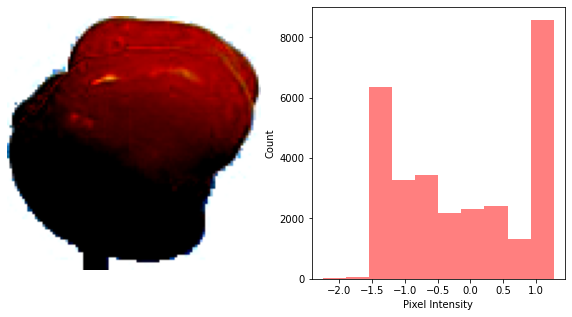

In [ ]:
x, y = next(iter(loaders['train']))
img_norm = x[0].permute(1,2,0).numpy()
plotHist(img_norm)

**So we can see the number of classes, there are really a lot of them**

In [ ]:
len(training.classes)

131

**Since information is always better perceived visually, I will make a graph with the distribution of classes**

In [ ]:
dic = {}

for classes in training.classes:
    for filename in os.listdir(path+'/Training/'+classes):
        dic[classes] = [len([os.path.join(path+'/Training/'+classes, filename) for filename in os.listdir(path+'/Training/'+classes)])]

    
train_samplesize = pd.DataFrame.from_dict(dic)

In [ ]:
train_samplesize

,Apple Braeburn,Apple Crimson Snow,Apple Golden 1,Apple Golden 2,Apple Golden 3,Apple Granny Smith,Apple Pink Lady,Apple Red 1,Apple Red 2,Apple Red 3,Apple Red Delicious,Apple Red Yellow 1,Apple Red Yellow 2,Apricot,Avocado,Avocado ripe,Banana,Banana Lady Finger,Banana Red,Beetroot,Blueberry,Cactus fruit,Cantaloupe 1,Cantaloupe 2,Carambula,Cauliflower,Cherry 1,Cherry 2,Cherry Rainier,Cherry Wax Black,Cherry Wax Red,Cherry Wax Yellow,Chestnut,Clementine,Cocos,Corn,Corn Husk,Cucumber Ripe,Cucumber Ripe 2,Dates,...,Pear Williams,Pepino,Pepper Green,Pepper Orange,Pepper Red,Pepper Yellow,Physalis,Physalis with Husk,Pineapple,Pineapple Mini,Pitahaya Red,Plum,Plum 2,Plum 3,Pomegranate,Pomelo Sweetie,Potato Red,Potato Red Washed,Potato Sweet,Potato White,Quince,Rambutan,Raspberry,Redcurrant,Salak,Strawberry,Strawberry Wedge,Tamarillo,Tangelo,Tomato 1,Tomato 2,Tomato 3,Tomato 4,Tomato Cherry Red,Tomato Heart,Tomato Maroon,Tomato Yellow,Tomato not Ripened,Walnut,Watermelon
0,492,444,480,492,481,492,456,492,492,429,490,492,672,492,427,491,490,450,490,450,462,490,492,492,490,702,492,738,738,492,492,492,450,490,490,450,462,392,468,490,...,490,490,444,702,666,666,492,492,490,493,490,447,420,900,492,450,450,453,450,450,490,492,490,492,490,492,738,490,490,738,672,738,479,492,684,367,459,474,735,475


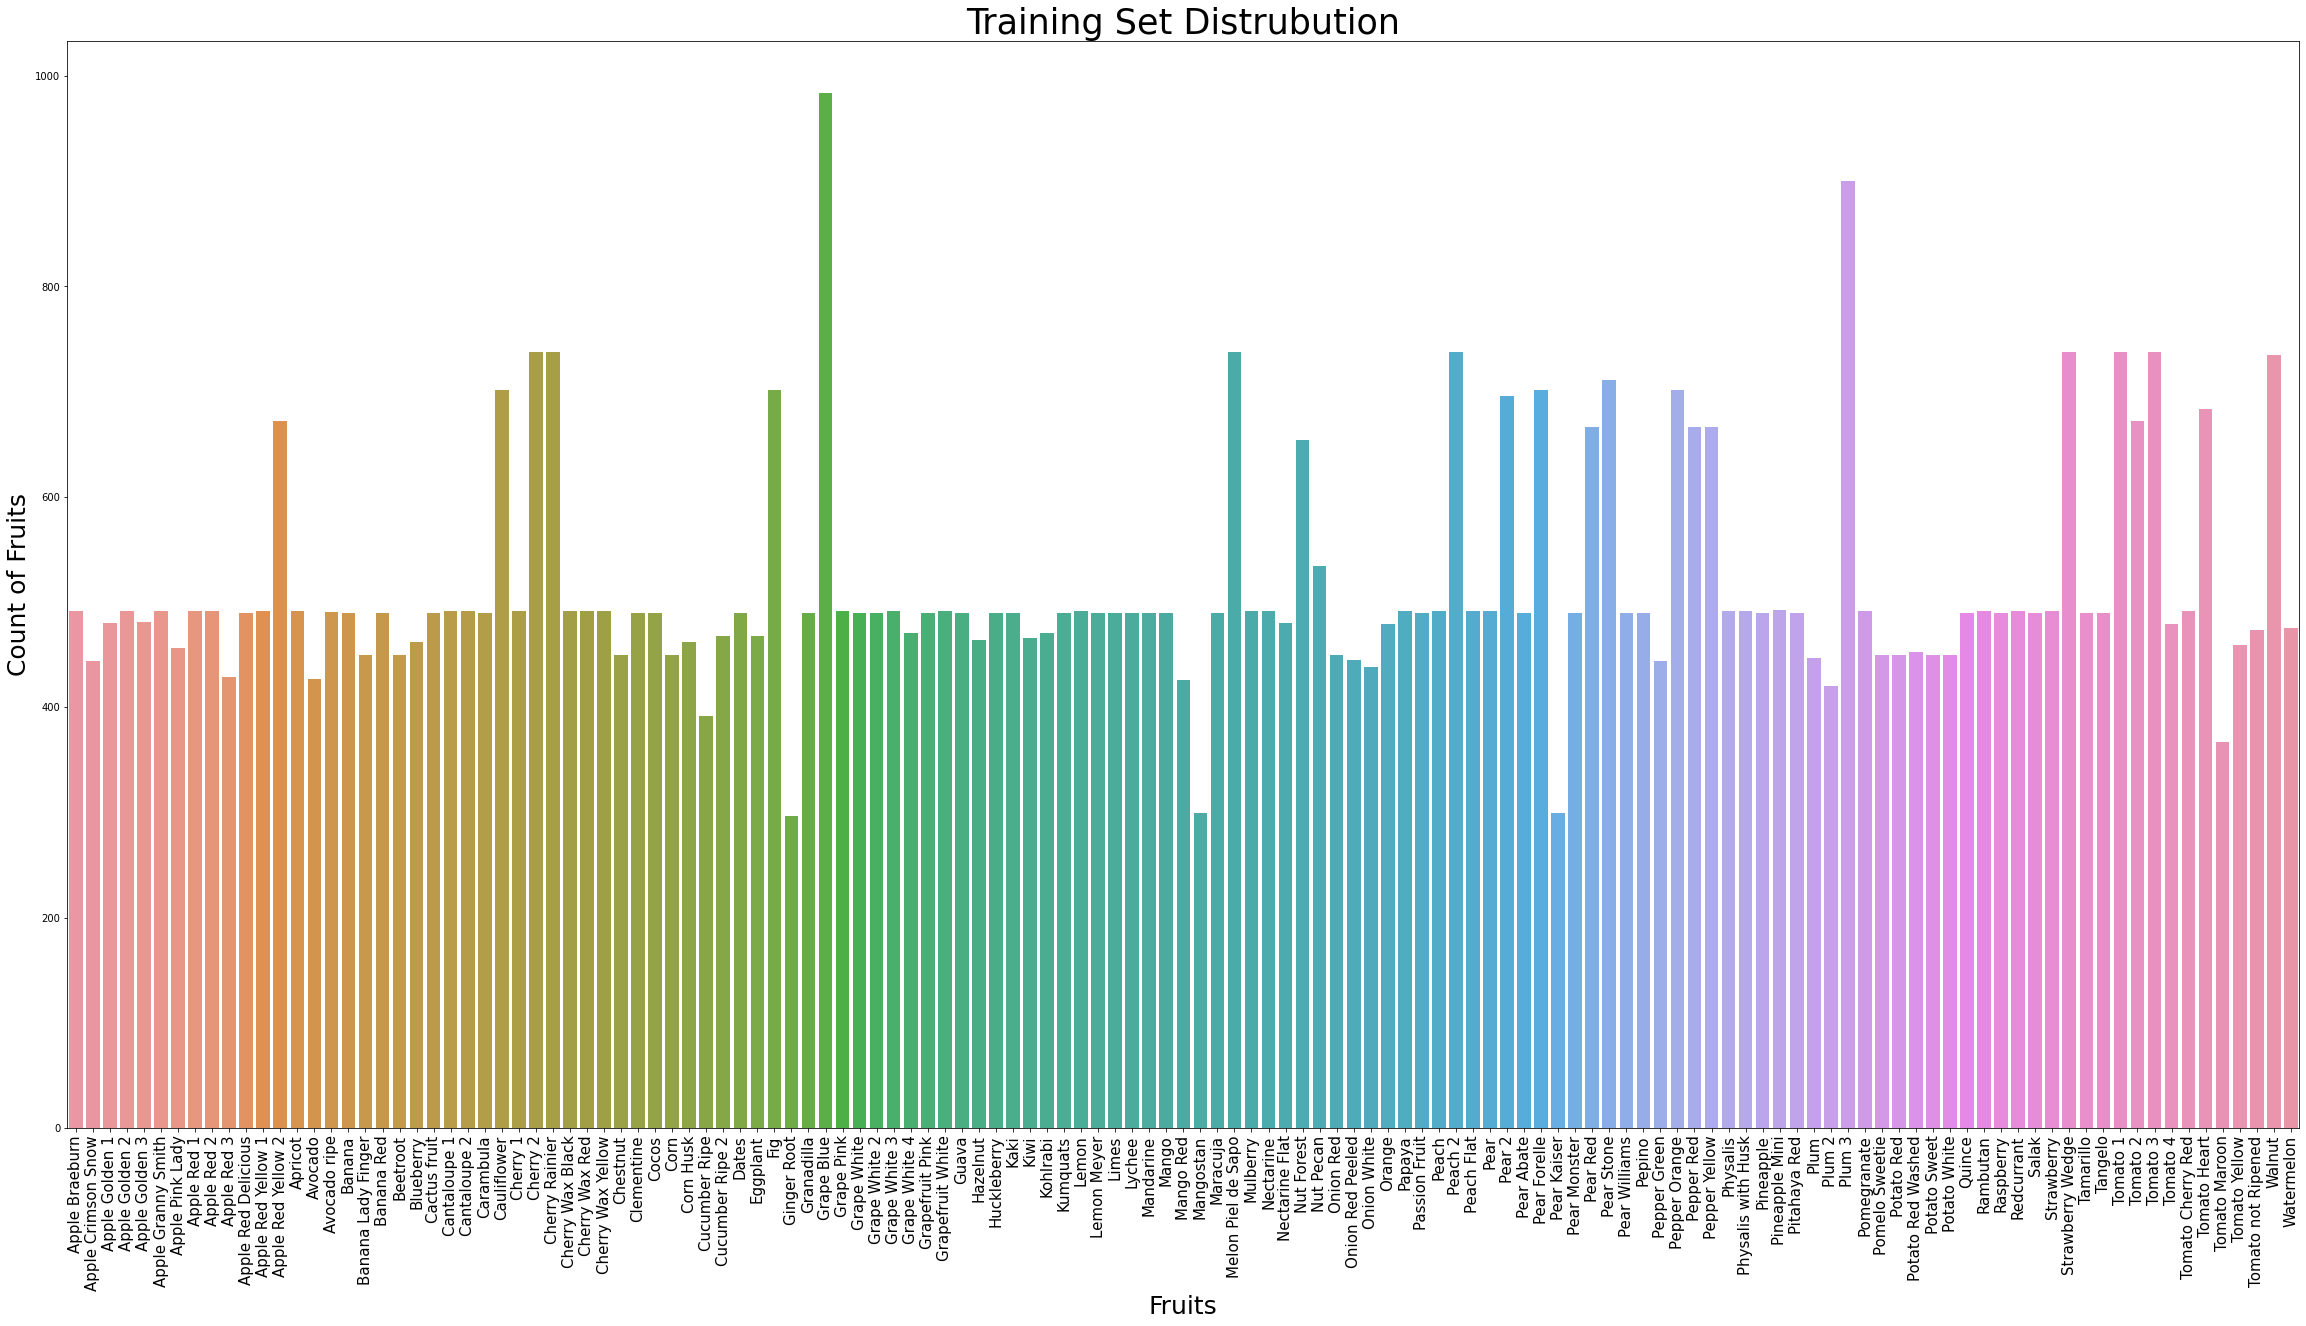

In [ ]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size

sns.barplot(data=train_samplesize)

index = np.arange(len(training.classes))

plt.xlabel('Fruits', fontsize=25)
plt.ylabel('Count of Fruits', fontsize=25)
plt.xticks(index, training.classes, fontsize=15, rotation=90)
plt.title('Training Set Distrubution', fontsize=35)
plt.show()

**Let's look at the data itself, which we will need to work with**

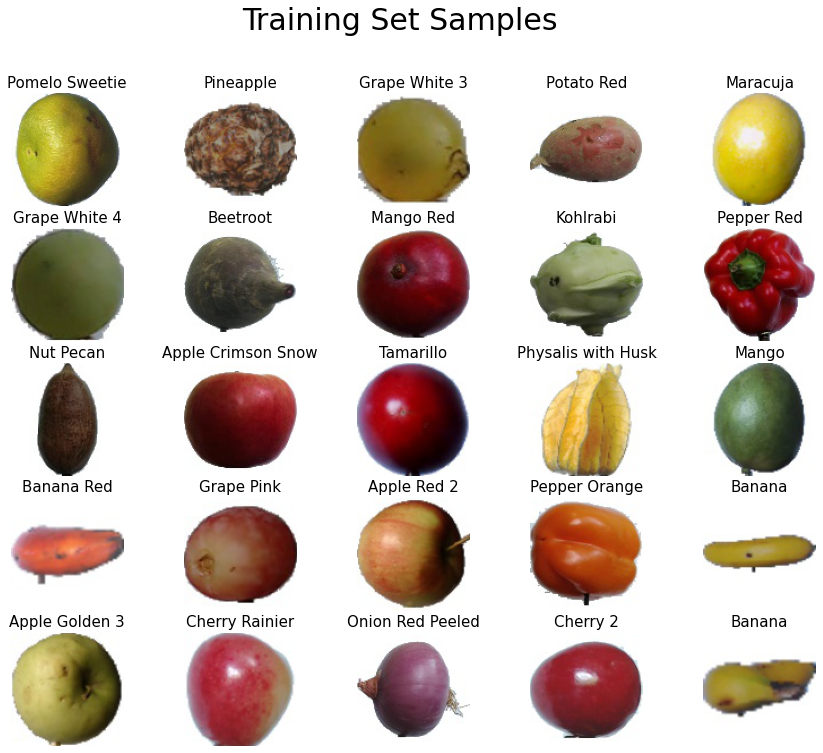

In [ ]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(training.classes)
    rand_samples.append([random.sample([os.path.join(path+'/Training/'+classes, filename) for filename in os.listdir(path+'/Training/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

# **3. Training**
**I will use an ensemble of pre-trained models, the idea is this: I first train only the classifier on 10 epochs, then unfreeze the network and train all together for another 10 epochs**

**Let's write the accuracy function so that we don't have to write it several times**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

**Learning history for further visualization**

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Train function structure:

1. **Classifier Training**
2. **Network-wide Training**

In [ ]:
def train(seed, epochs, model):
  print('Creating a model {}...'.format(seed))

  model.to(device)
  criterion = nn.CrossEntropyLoss()
  if seed==2 or seed==3:
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  else:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
          acc = 100. * running_corrects.double() / dataset_sizes[phase]
          scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time() - since)//60, (time.time()- since)%60))
        print('=='*31)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('CLASSIFIER TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)


  model.load_state_dict(best_model)

  for param in model.parameters():
        param.requires_grad=True

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)  
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
  #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
        acc = 100. * running_corrects.double() / dataset_sizes[phase]
        scheduler.step(acc)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
        print('=='*31)    
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    #scheduler.step() 
  time_elapsed = time.time() - since
  print('ALL NET TRAINING TIME {}m {}s'.format(time_elapsed//60, time_elapsed%60))
  print('=='*31)

  model.load_state_dict(best_model)
  return model

**Uploading models**

In [ ]:
densenet121_0 = torchvision.models.densenet121(pretrained=True)
for param in densenet121_0.parameters():
  param.requires_grad=False

densenet121_0.classifier = nn.Linear(in_features=densenet121_0.classifier.in_features, out_features=len(training.classes), bias=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
# densenet121_1 = torchvision.models.densenet121(pretrained=True)
# for param in densenet121_1.parameters():
#   param.requires_grad=False

# densenet121_1.classifier = nn.Linear(in_features=densenet121_1.classifier.in_features, out_features=len(training.classes), bias=True)

In [ ]:
# googlenet = torchvision.models.googlenet(pretrained=True)
# for param in googlenet.parameters():
#   param.grad_requires = False

# googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=len(training.classes), bias=True)

In [ ]:
# resnet101 = torchvision.models.resnet101(pretrained=True)
# for param in resnet101.parameters():
#   param.grad_requires = False

# resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=len(training.classes), bias=True)

In [ ]:
# vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
# for param in vgg19_bn.parameters():
#   param.grad_requires = False

# vgg19_bn.classifier[6] = nn.Linear(4096, len(training.classes), bias=True)

In [ ]:
# del densenet121_1, googlenet, resnet101, vgg19_bn

**Launching training**

In [ ]:
num_models = 5
epochs = 10

# models = [densenet121_0, densenet121_1, googlenet, resnet101, vgg19_bn]

In [ ]:
train(seed=0, epochs=epochs, model=densenet121_0)

Creating a model 0...
Epoch: 1/10
train - loss:0.265860628858065, accuracy0.9666132769371919
val - loss:0.013606926581741171, accuracy0.9997045790251107
Time: 1.0m 3.8554346561431885s
Epoch: 2/10
train - loss:0.017997782745479522, accuracy0.999657891053851
val - loss:0.013606926581741171, accuracy0.9997045790251107
Time: 2.0m 8.751772165298462s
Epoch: 3/10
train - loss:0.017997782745479522, accuracy0.999657891053851
val - loss:0.013606926581741171, accuracy0.9997045790251107
Time: 3.0m 13.475590229034424s
Epoch: 4/10
train - loss:0.017997782745479522, accuracy0.999657891053851
val - loss:0.013606926581741171, accuracy0.9997045790251107
Time: 4.0m 18.362090349197388s
Epoch: 5/10
train - loss:0.017997782745479522, accuracy0.999657891053851
val - loss:0.013606926581741171, accuracy0.9997045790251107
Time: 5.0m 23.349651336669922s
Epoch: 6/10
train - loss:0.017997782745479522, accuracy0.999657891053851
val - loss:0.013606926581741171, accuracy0.9997045790251107
Time: 6.0m 28.31605863571167

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
torch.save(densenet121_0.state_dict(), 'weights_dense.wght')

# **4. Test**

**Visualization of training. As we can see, after defrosting, the indicators have improved**

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
modelname = ['DenseNet_0', 'DenseNet_1', 'GooglNet', 'ResNet101', 'VGG16 with BN']

epochs=10

i=0

for row in range(5):

  epoch_list = list(range(1,epochs*2+1))

  ax[row][0].plot(epoch_list, accuracies['train'][i:20+i], '-o', label='Train Accuracy')
  ax[row][0].plot(epoch_list, accuracies['val'][i:20+i], '-o', label='Validation Accuracy')
  ax[row][0].plot([epochs for x in range(20)],  np.linspace(min(accuracies['train'][i:20+i]).cpu(), max(accuracies['train'][i:20+i]).cpu(), 20), color='r', label='Unfreeze net')
  ax[row][0].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][0].set_ylabel('Accuracy Value')
  ax[row][0].set_xlabel('Epoch')
  ax[row][0].set_title('Accuracy {}'.format(modelname[row]))
  ax[row][0].legend(loc="best")

  ax[row][1].plot(epoch_list, losses['train'][i:20+i], '-o', label='Train Loss')
  ax[row][1].plot(epoch_list, losses['val'][i:20+i], '-o',label='Validation Loss')
  ax[row][1].plot([epochs for x in range(20)], np.linspace(min(losses['train'][i:20+i]), max(losses['train'][i:20+i]), 20), color='r', label='Unfreeze net')
  ax[row][1].set_xticks(np.arange(0, epochs*2+1, 5))
  ax[row][1].set_ylabel('Loss Value')
  ax[row][1].set_xlabel('Epoch')
  ax[row][1].set_title('Loss {}'.format(modelname[row]))
  ax[row][1].legend(loc="best")
  fig.tight_layout()
  fig.subplots_adjust(top=1.5, wspace=0.3)

  i+=20

**Let's write a model class that contains 5 already trained models**

In [ ]:
class Ensemble(nn.Module):
    def __init__(self, device):
        super(Ensemble,self).__init__()
        # you should use nn.ModuleList. Optimizer doesn't detect python list as parameters
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        # it is super simple. just forward num_ models and concat it.
        output = torch.zeros([x.size(0), len(training.classes)]).to(device)
        for model in self.models:
            output += model(x)
        return output


In [ ]:
model =  Ensemble(device)

**Let's write some functions that will help us make predictions and load the test data**

In [ ]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [ ]:
 def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
testset = ImageFolder(path+'/Test', 
                           transform=transformer)

In [ ]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)

# **4. Metrics**

**To visualize the data qualitatively, we need to normalize it back, that is, to return the pixel brightness distribution to its original state. This is what the function below does**

In [ ]:
def norm_out(img):
    
    img = img.permute(1,2,0)
    mean = torch.FloatTensor([0.6840562224388123, 0.5786514282226562, 0.5037682056427002])
    std = torch.FloatTensor([0.3034113645553589, 0.35993242263793945, 0.39139702916145325])
    
    img = img*std + mean
        
    return np.clip(img,0,1)

**Let's see how confident the network is in its predictions, as you can see, the network has trained well and gives confident predictions**

In [ ]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    i = np.random.randint(0, high=len(testset))
    img,label = testset[i]
    
    m = nn.Softmax(dim=1)
    percent = m(model(img.to(device).unsqueeze(0)))
    predmax3percent = torch.sort(percent[0])[0][-3:]
    predmax3inds = torch.sort(percent[0])[1][-3:]
    classes = np.array([training.classes[predmax3inds[-3]], training.classes[predmax3inds[-2]],training.classes[predmax3inds[-1]]])
    class_name = training.classes

    ax[row][0].imshow(norm_out(img))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, predmax3percent.detach().cpu().numpy())
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_title('Predicted Class: {} ({}%)'.format(training.classes[predmax3inds[-1]], round((predmax3percent[-1]*100).item(), 2)))
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()

**Here you can see the main metrics for each individual class**

In [ ]:
report = classification_report(labels, preds,
                               output_dict=True,
                               target_names=training.classes)
report_df = pd.DataFrame(report).transpose()

In [ ]:
pd.set_option("display.max_rows", None)
report_df.head(134)

***I am always happy to receive any feedback. What do you think can be changed and what can be removed?***